In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset


# Load the data
data = pd.read_csv('consumption_temp.csv')

# Filter for 'Oslo'
oslo_data = data[data['location'] == 'oslo']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(oslo_data[['consumption', 'temperature']])

device = torch.device('cpu')

print(torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

def create_sequences(data, seq_length, pred_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length - pred_length + 1):
        sequences.append(data[i:i+seq_length])
        target.append(data[i+seq_length:i+seq_length+pred_length, 0])  # 'consumption' for the next 24 hours
    return torch.tensor(np.array(sequences), device = device, dtype=torch.float32).float(), torch.tensor(np.array(target), device = device, dtype=torch.float32).float()

seq_length = 120  # 5 days * 24 hours
pred_length = 24  # 1 day * 24 hours
X, y = create_sequences(scaled_data, seq_length, pred_length)


# Split into training and test sets
train_size = int(0.8 * len(X))
X_train_seq = X[:train_size]
y_train_seq = y[:train_size]
X_test_seq = X[train_size:]
y_test_seq = y[train_size:]


# Create DataLoader
batch_size = 64  # You can adjust this based on memory availability
train_dataset = TensorDataset(X_train_seq, y_train_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_seq, y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, pred_length):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim * pred_length)  # Ensure the final layer produces pred_length outputs
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device, dtype=torch.float32).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device, dtype=torch.float32).requires_grad_()
        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm2(out)
        out = self.dropout(out[:, -1, :])  # Use the last timestep output for prediction
        out = self.fc(out)
        return out

class LSTMTrainer:
    def __init__(self, model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.train_losses = []
        self.val_losses = []

    def train(self):
        for epoch in tqdm(range(self.num_epochs)):  # Wrap around tqdm for progress bar
            # Training
            self.model.train()
            running_loss = 0.0
            for X_batch, y_batch in self.train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * X_batch.size(0)
            self.train_losses.append(running_loss / len(self.train_loader.dataset))

            # Evaluation
            self.model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in self.test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    val_outputs = self.model(X_batch)
                    val_loss = self.criterion(val_outputs, y_batch)
                    running_val_loss += val_loss.item() * X_batch.size(0)
            self.val_losses.append(running_val_loss / len(self.test_loader.dataset))

            # Scheduler step
            self.scheduler.step()

def initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, device):
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, pred_length)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    return model, criterion, optimizer, scheduler

def create_lstm_data_loaders(X_train_seq, y_train_seq, X_test_seq, y_test_seq, batch_size):
    train_dataset = TensorDataset(X_train_seq, y_train_seq)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test_seq, y_test_seq)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs):
    trainer = LSTMTrainer(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=num_epochs)
    trainer.train()
    return trainer

# Initialize the model, criterion, optimizer, and scheduler
input_dim = 2
hidden_dim = 100
num_layers = 2
output_dim = 1
model, criterion, optimizer, scheduler = initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, device)

# Create DataLoader
batch_size = 64  # You can adjust this based on memory availability
train_loader, test_loader = create_lstm_data_loaders(X_train_seq, y_train_seq, X_test_seq, y_test_seq, batch_size)

# Train the model
num_epochs = 50
trainer = train_lstm_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs)

# Print the training and validation losses
print(trainer.train_losses)
print(trainer.val_losses)


False
mps


/var/folders/k0/gx88kp513zqbj9_8ls33bwbh0000gn/T/ipykernel_96387/1080922648.py:27: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif torch.has_mps:
100%|██████████| 50/50 [03:34<00:00,  4.29s/it]

[0.4686190123946816, 0.19474560656278195, 0.10862240887943805, 0.05314841693654661, 0.03807549637932222, 0.03612448905396546, 0.03514760321871468, 0.03347545777586987, 0.03341494254750359, 0.032318177664497384, 0.03023648558545635, 0.028585955130156084, 0.02395472015881931, 0.019504466345881707, 0.018588414902339336, 0.018573012597536683, 0.058498318732622165, 0.03405437971514336, 0.03313051436614836, 0.03264486356072564, 0.03154436210633447, 0.03131341227396301, 0.030587016795270056, 0.029839003205992046, 0.02982786622432163, 0.027732924414372823, 0.027213427756846424, 0.026785816247080416, 0.026358384401193608, 0.024277094073174944, 0.020439838686430234, 0.01872361587729304, 0.017125960359435883, 0.01668761857621159, 0.01684632075160838, 0.015982218753085062, 0.0150450094350649, 0.015360125432584998, 0.01512443753949603, 0.014787195014752827, 0.013967781155319487, 0.014275156419091837, 0.013727540187822629, 0.014195732100504782, 0.013677226137298631, 0.013276325760693647, 0.013330297

In [41]:
print(X_train_seq.shape)
print(X_test_seq.shape)
print(y_train_seq.shape)
print(y_test_seq.shape)

torch.Size([6798, 120, 2])
torch.Size([1700, 120, 2])
torch.Size([6798, 24])
torch.Size([1700, 24])


Mean Absolute Error (MAE): 0.1769077628850937
Mean Squared Error (MSE): 0.052109286189079285
Root Mean Squared Error (RMSE): 0.22827458381652832
R-squared: 0.567191640714405


/var/folders/k0/gx88kp513zqbj9_8ls33bwbh0000gn/T/ipykernel_96387/3936118103.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oslo_data['time'] = pd.to_datetime(oslo_data['time'])


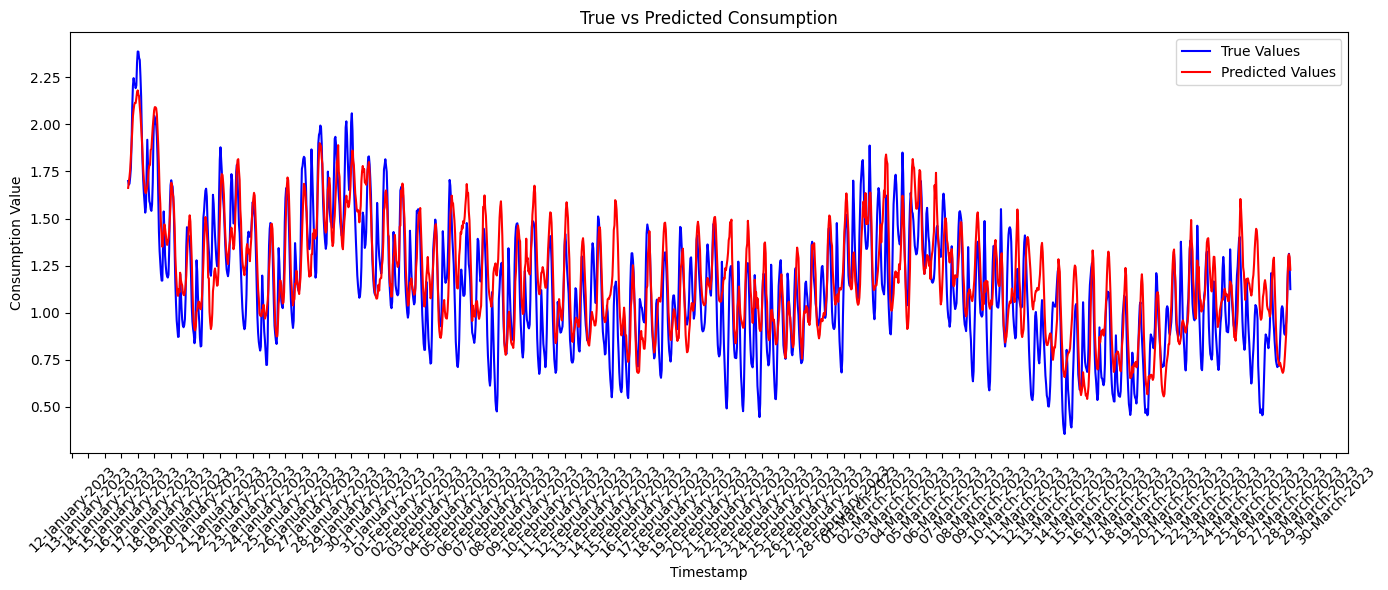

In [60]:
import matplotlib.dates as mdates
from datetime import datetime, timedelta

X_test_seq = X_test_seq.to(device)

# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_seq)


# Convert predictions and actual values to numpy arrays for calculation
y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test_seq.cpu().numpy()

# Compute Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

import matplotlib.pyplot as plt

# Get true values for the next 24 hours from each sequence
true_values = y_test_np[:, -1]  # Get the last value from each sequence

# Get the predicted values for 24 hours ahead
predicted_values = y_pred_np[:, -1]

# Convert the 'timestamp' column to datetime format
oslo_data['time'] = pd.to_datetime(oslo_data['time'])

# Get the starting timestamp of the test set
initial_timestamp = oslo_data['time'].iloc[train_size + seq_length]  # The start of the test set, adjusted for the sequence length

# Generate a range of timestamps for the test set, taking every 24th hour since we're predicting for 24 hours ahead
timestamps = [initial_timestamp + pd.Timedelta(hours=i*24) for i in range(len(true_values))]

# Extracting the start date from the test dataset
start_date = oslo_data.iloc[train_size]['time'].to_pydatetime()

# Generating timestamps for each hour in the test set
hours = len(y_test_seq)
timestamps = [start_date + timedelta(hours=i) for i in range(hours)]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(timestamps, true_values, label='True Values', color='blue')
plt.plot(timestamps, predicted_values, label='Predicted Values', color='red')
plt.legend()
plt.title('True vs Predicted Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption Value')

# Customizing the x-axis to show a label only at the start of every new day
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%B-%Y'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))  # place a major tick every 24 hours (i.e., every day)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


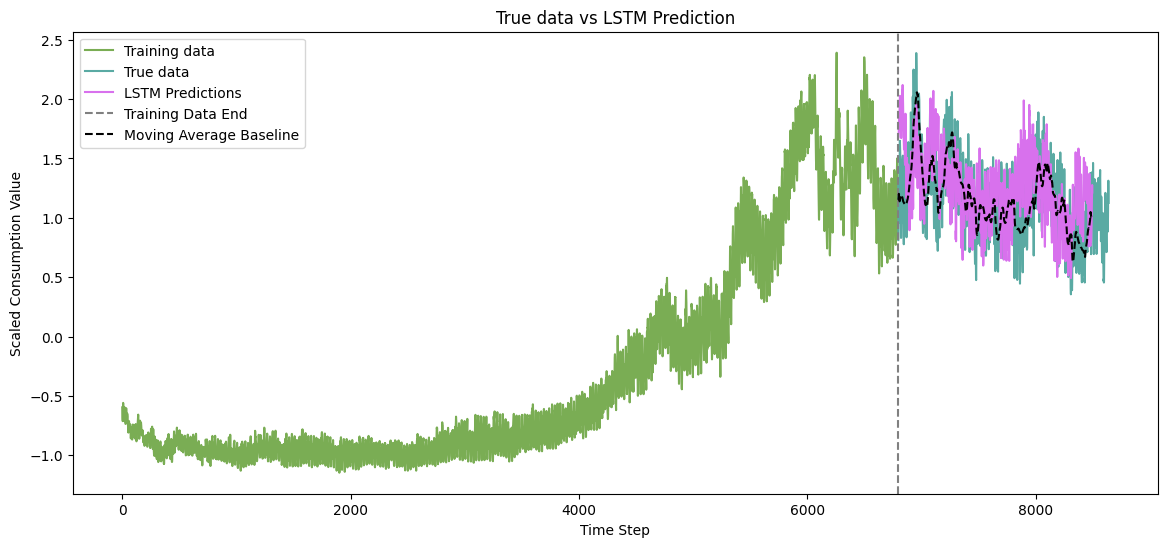

Moving Average Baseline Metrics:
Mean Absolute Error (MAE): 0.3055552602875524
Mean Squared Error (MSE): 0.1466502697570664
Root Mean Squared Error (RMSE): 0.3829494349872662
R-squared: -0.2630052331893633

LSTM Model Metrics:
Mean Absolute Error (MAE): 0.19107812643051147
Mean Squared Error (MSE): 0.060120176523923874
Root Mean Squared Error (RMSE): 0.24519416689872742
R-squared: 0.48222329360332705


In [8]:
# Create a rolling mean baseline using rolling() and mean()
rolling_mean_values = pd.Series(scaled_data[:, 0]).rolling(window=24).mean()
# Filter to just use test data
rolling_mean_values = rolling_mean_values.iloc[train_size:train_size+len(predicted_values)]


# Create a plot with scaled data and predictions
plt.figure(figsize=(14, 6))
plt.plot(scaled_data[:train_size, 0], label='Training data', color='#7AAD54')  # plot the first column of scaled_data before the vertical line
plt.plot(range(train_size, len(scaled_data)), scaled_data[train_size:, 0], label='True data', color='#5AAAA3')  # plot the first column of scaled_data after the vertical line
plt.plot(range(train_size, train_size+len(predicted_values)), predicted_values, label='LSTM Predictions', color='#D871ED')
plt.axvline(x=train_size, linestyle='--', color='gray', label='Training Data End')  # add a vertical line at the end of the training data
plt.plot(range(train_size, train_size+len(predicted_values)), rolling_mean_values, linestyle='--', color='black', label='Moving Average Baseline')  # add a horizontal line for the moving average baseline
plt.legend()
plt.title('True data vs LSTM Prediction')
plt.xlabel('Time Step')
plt.ylabel('Scaled Consumption Value')
plt.show()

# Print error metrics for the moving average baseline and the LSTM model compared to the true values
mae_baseline = mean_absolute_error(true_values, rolling_mean_values)
mse_baseline = mean_squared_error(true_values, rolling_mean_values)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(true_values, rolling_mean_values)

mae_lstm = mean_absolute_error(true_values, predicted_values)
mse_lstm = mean_squared_error(true_values, predicted_values)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(true_values, predicted_values)

print(f"Moving Average Baseline Metrics:")
print(f"Mean Absolute Error (MAE): {mae_baseline}")
print(f"Mean Squared Error (MSE): {mse_baseline}")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline}")
print(f"R-squared: {r2_baseline}")
print()
print(f"LSTM Model Metrics:")
print(f"Mean Absolute Error (MAE): {mae_lstm}")
print(f"Mean Squared Error (MSE): {mse_lstm}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm}")
print(f"R-squared: {r2_lstm}")




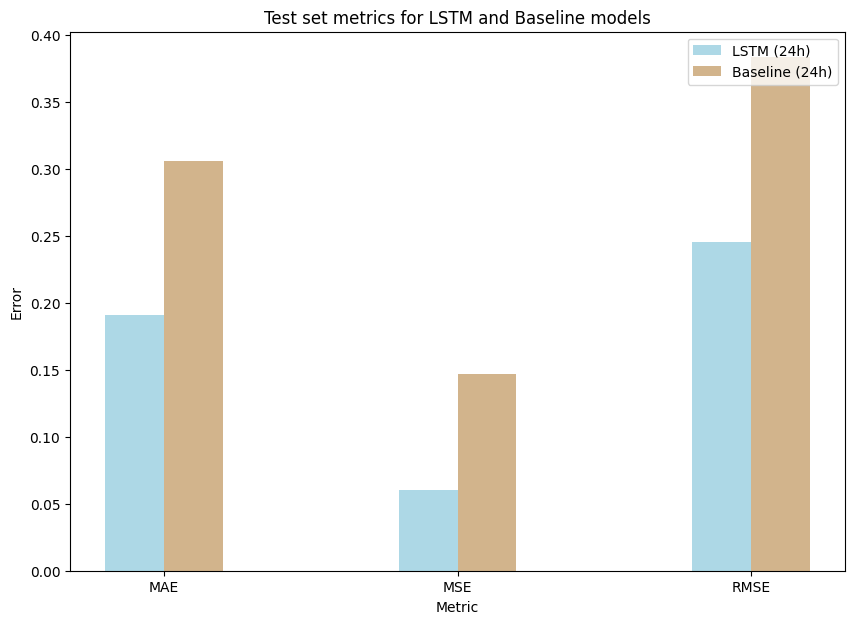

In [14]:
#MAE, MSE, RMSE, R2
lstm_values = [mae_lstm, mse_lstm, rmse_lstm]
baseline_values = [mae_baseline, mse_baseline, rmse_baseline]

labels = ['MAE', 'MSE', 'RMSE']
bar_width = 0.2

r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(figsize=(10, 7))

# Create bars
plt.bar(r1, lstm_values, width=bar_width, label='LSTM (24h)', color='lightblue')
plt.bar(r2, baseline_values, width=bar_width, label='Baseline (24h)', color='tan')

# Add some details
plt.title('Test set metrics for LSTM and Baseline models')
plt.xlabel('Metric')
plt.ylabel('Error')
plt.xticks([r + bar_width*0.5 for r in range(len(labels))], labels)
plt.legend(loc='upper right')


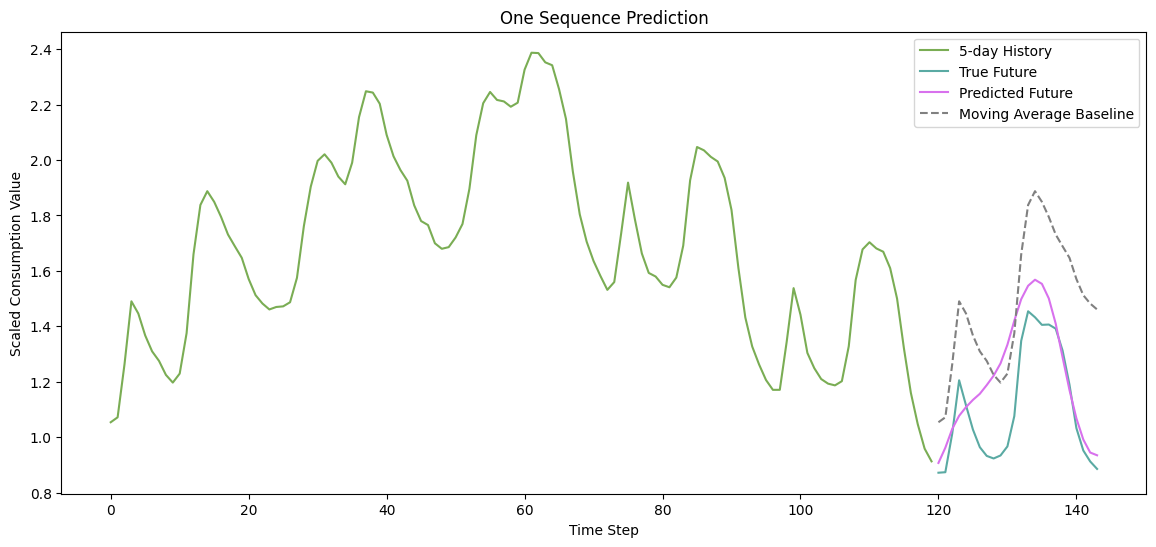

In [12]:
sequence_nr = 4*24  # 4 days * 24 hours

# Create a rolling mean baseline using rolling() and mean() from the test data filtered to just use the selected sequence
rolling_mean_values = pd.Series(scaled_data[train_size+sequence_nr:train_size+sequence_nr+pred_length, 0]).rolling(window=1).mean()

# Convert X_test_seq[sequence_nr] to numpy array if it's a tensor on a non-CPU device
X_test_seq_cpu = X_test_seq[sequence_nr].cpu().numpy()

# Convert y_test_seq[sequence_nr] to numpy array if it's a tensor on a non-CPU device
y_test_seq_cpu = y_test_seq[sequence_nr].cpu().numpy()

# Convert y_pred[sequence_nr] to numpy array if it's a tensor on a non-CPU device
y_pred_cpu = y_pred[sequence_nr].cpu().numpy()

# Plot a graph showing the predicted value of one sequence and the actual values for the next 24 hours with the 5-day history
plt.figure(figsize=(14, 6))
plt.plot(range(seq_length), X_test_seq_cpu[:, 0], label='5-day History', color='#7AAD54')
plt.plot(range(seq_length, seq_length+pred_length), y_test_seq_cpu, label='True Future', color='#5AAAA3')
plt.plot(range(seq_length, seq_length+pred_length), y_pred_cpu, label='Predicted Future', color='#D871ED')
plt.plot(range(seq_length, seq_length+pred_length), rolling_mean_values, linestyle='--', label='Moving Average Baseline', color='gray')
plt.legend()
plt.title('One Sequence Prediction')
plt.xlabel('Time Step')
plt.ylabel('Scaled Consumption Value')
plt.show()



In [52]:
# Time series split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tscv = TimeSeriesSplit(n_splits=5)
mae_TSS = []
mse_TSS = []
rmse_TSS = []
r2_TSS = []

X, y = create_sequences(scaled_data, seq_length, pred_length)

training_data_list = []
y_pred_np_list = []
y_test_np_list = []

for train_index, test_index in tscv.split(X):
    cv_train, cv_test = X[train_index], X[test_index]
    cv_train_target, cv_test_target = y[train_index], y[test_index]

    # Create DataLoader
    batch_size = 64  # You can adjust this based on memory availability
    cv_train_dataset = TensorDataset(cv_train, cv_train_target)
    cv_train_loader = DataLoader(cv_train_dataset, batch_size=batch_size, shuffle=True)

    cv_test_dataset = TensorDataset(cv_test, cv_test_target)
    cv_test_loader = DataLoader(cv_test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, criterion, optimizer, and scheduler
    input_dim = 2
    hidden_dim = 100
    num_layers = 2
    output_dim = 1
    model, criterion, optimizer, scheduler = initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, device)

    # Train the model
    num_epochs = 50
    trainer = train_lstm_model(model, criterion, optimizer, scheduler, cv_train_loader, cv_test_loader, num_epochs)
    
    # Make predictions on the test set
    model.eval()
    with torch.no_grad():
        y_pred = model(cv_test)

    # Convert predictions and actual values to numpy arrays for calculation
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = cv_test_target.cpu().numpy()

    # Append to lists
    training_data_list.append(cv_train)
    y_pred_np_list.append(y_pred_np)
    y_test_np_list.append(y_test_np)

    # Compute Evaluation Metrics
    mae_TSS.append(mean_absolute_error(y_test_np, y_pred_np))
    mse_TSS.append(mean_squared_error(y_test_np, y_pred_np))
    rmse_TSS.append(np.sqrt(mse_TSS[-1]))
    r2_TSS.append(r2_score(y_test_np, y_pred_np))

print("MAE", mae_TSS)
print("MSE", mse_TSS)
print("RMSE", rmse_TSS)
print("R2", r2_TSS)




100%|██████████| 50/50 [03:47<00:00,  4.54s/it]


MAE [0.07114702, 0.206074, 2.2617514, 0.40125862, 0.18814957]
MSE [0.007263982, 0.06482806, 6.3312798, 0.24100693, 0.058117464]
RMSE [0.085229, 0.25461355, 2.5162034, 0.49092457, 0.24107563]
R2 [0.005678934631018313, -0.8588657246972747, -27.960230574676967, -0.6803774832639539, 0.404691848327317]


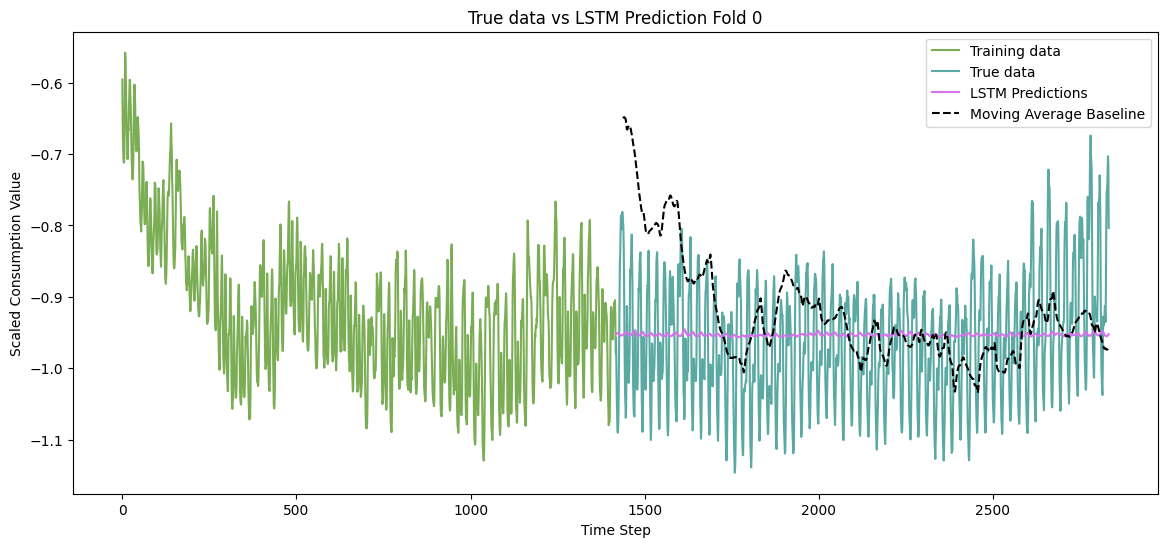

MAE 0.07114702
MSE 0.007263982
RMSE 0.085229
R2 0.005678934631018313


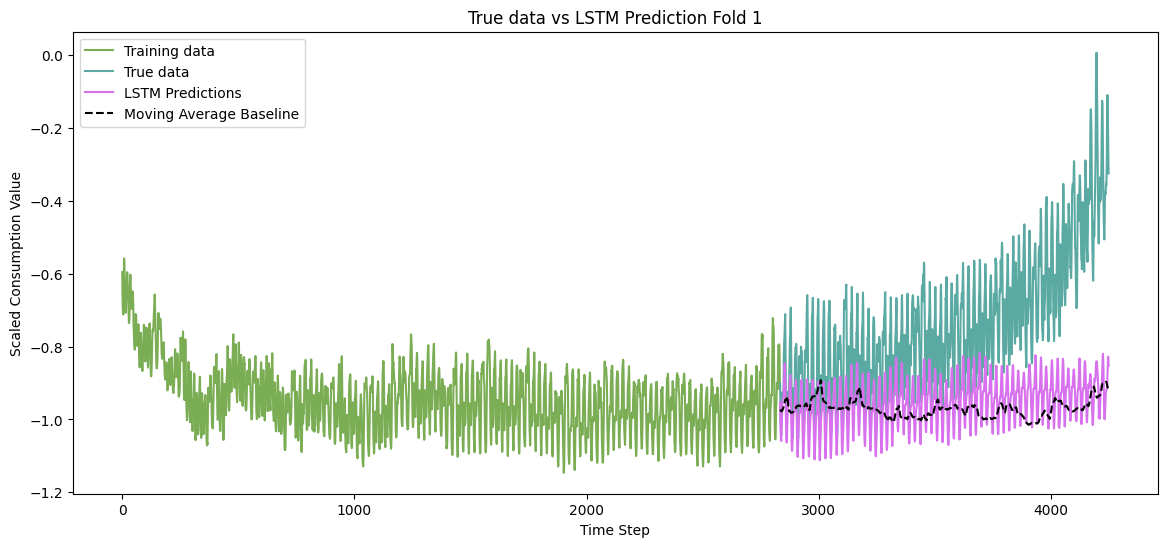

MAE 0.206074
MSE 0.06482806
RMSE 0.25461355
R2 -0.8588657246972747


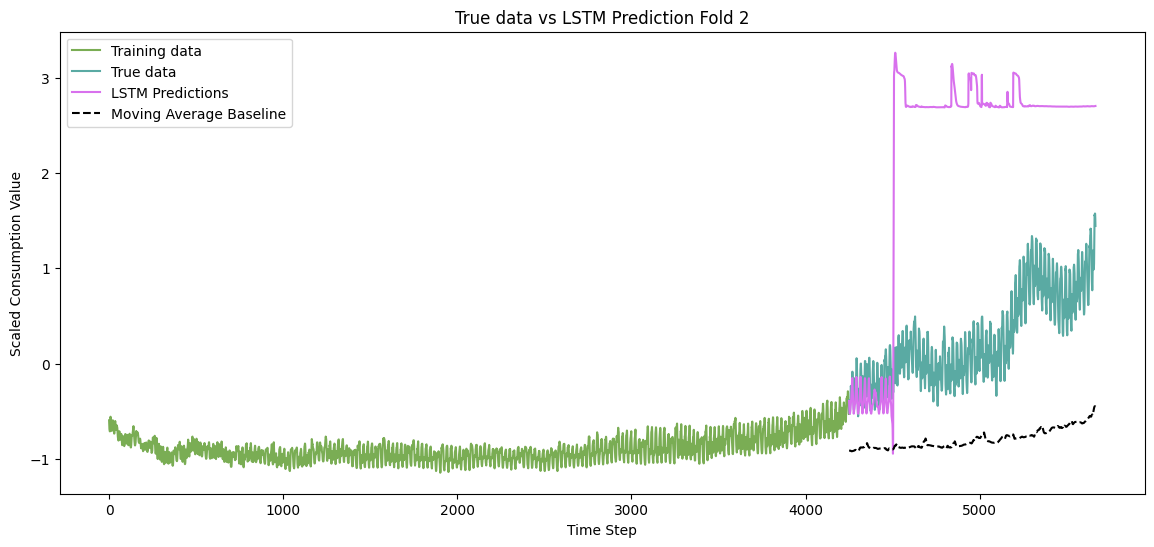

MAE 2.2617514
MSE 6.3312798
RMSE 2.5162034
R2 -27.960230574676967


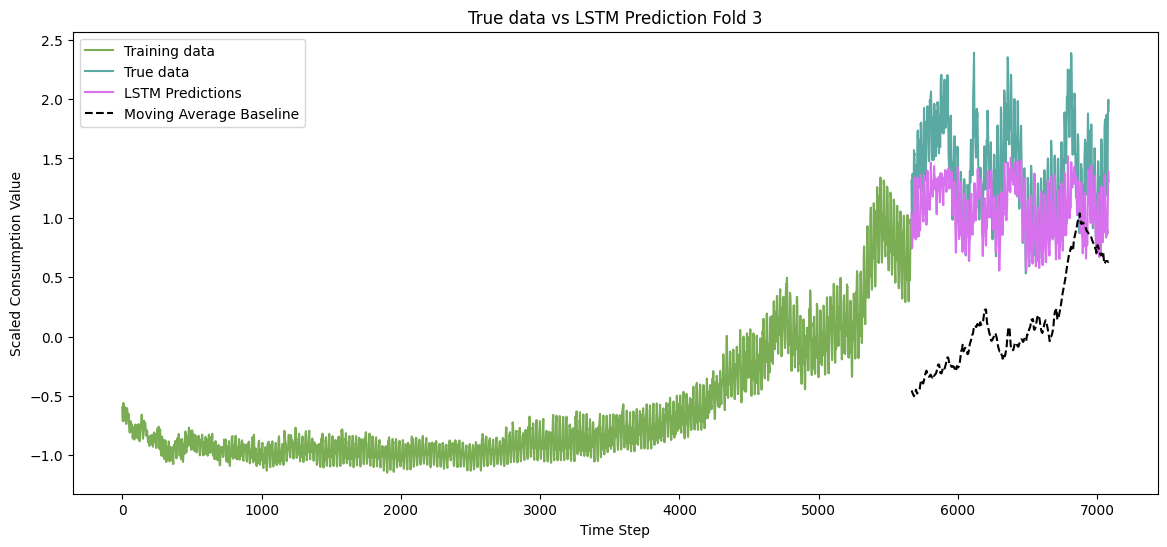

MAE 0.40125862
MSE 0.24100693
RMSE 0.49092457
R2 -0.6803774832639539


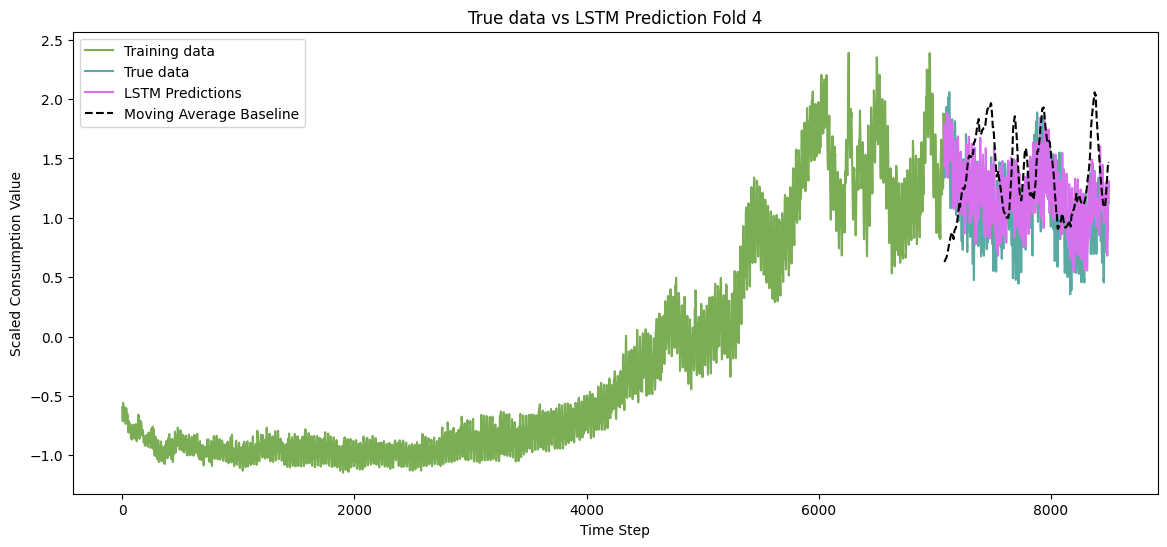

MAE 0.18814957
MSE 0.058117464
RMSE 0.24107563
R2 0.404691848327317


In [59]:
# For each fold, plot the predictions vs actual values
for fold_nr in range(0, 5):

    # Plot predictions vs actual values an training values
    train_values = training_data_list[fold_nr][:, 0, 0].reshape(-1, 1)


    true_values = y_test_np_list[fold_nr][:, -1]
    pred_values = y_pred_np_list[fold_nr][:, -1]

    # Create a rolling mean baseline using rolling() and mean()
    rolling_mean_values = pd.Series(train_values.cpu()[:, 0]).rolling(window=24).mean()
    # Filter to just use pred values
    rolling_mean_values = rolling_mean_values.iloc[-len(true_values):]

    plt.figure(figsize=(14, 6))
    plt.plot(train_values.cpu(), label='Training data', color='#7AAD54')
    plt.plot(range(len(train_values), len(train_values) + len(true_values)), true_values, label='True data', color='#5AAAA3')
    plt.plot(range(len(train_values), len(train_values) + len(true_values)), pred_values, label='LSTM Predictions', color='#D871ED')
    plt.plot(range(len(train_values), len(train_values) + len(true_values)), rolling_mean_values, linestyle='--', color='black', label='Moving Average Baseline')  # add a horizontal line for the moving average baseline
    plt.legend()
    plt.title('True data vs LSTM Prediction Fold ' + str(fold_nr))
    plt.xlabel('Time Step')
    plt.ylabel('Scaled Consumption Value')
    plt.show()

    print("MAE", mae_TSS[fold_nr])
    print("MSE", mse_TSS[fold_nr])
    print("RMSE", rmse_TSS[fold_nr])
    print("R2", r2_TSS[fold_nr])

In [62]:
print("MAE", mae_TSS)

#Array of metrics
TSS_error_metrics = np.array([np.mean(mae_TSS), np.mean(mse_TSS), np.mean(rmse_TSS), np.mean(r2_TSS)])

# Array with all folds
TSS_error_metrics_folds = [mae_TSS, mse_TSS, rmse_TSS, r2_TSS]

print(f"Mean Absolute Error (MAE): {np.mean(mae_TSS)}")
print(f"Mean Squared Error (MSE): {np.mean(mse_TSS)}")
print(f"Root Mean Squared Error (RMSE): {np.mean(rmse_TSS)}")
print(f"R-squared: {np.mean(r2_TSS)}")

MAE [0.07114702, 0.206074, 2.2617514, 0.40125862, 0.18814957]
Mean Absolute Error (MAE): 0.625676155090332
Mean Squared Error (MSE): 1.3404991626739502
Root Mean Squared Error (RMSE): 0.7176092267036438
R-squared: -5.817820599935972


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).

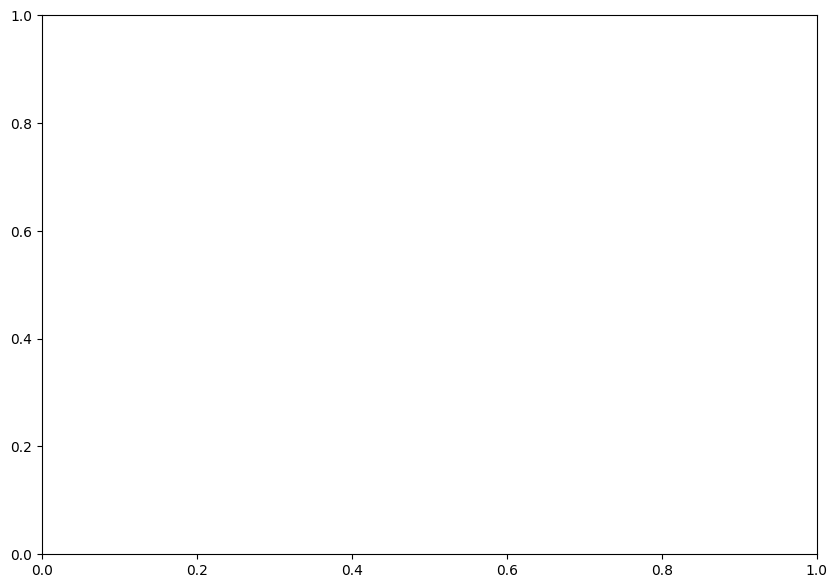

In [66]:
#MAE, MSE & RMSE for each fold
for fold_nr in range(0, 5):
    # Remove r2 from the array
    fold_metrics = TSS_error_metrics_folds[fold_nr][:-1]
    baseline_values = [mae_baseline, mse_baseline, rmse_baseline]

    print(fold_metrics.shape())
    print(baseline_values.shape())

    labels = ['MAE', 'MSE', 'RMSE']
    bar_width = 0.2

    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]

    fig, ax = plt.subplots(figsize=(10, 7))

    # Create bars
    plt.bar(r1, fold_metrics, width=bar_width, label='LSTM Cross Validation Fold' + str(fold_nr), color='lightblue')
    plt.bar(r2, baseline_values, width=bar_width, label='Baseline (24h)', color='tan')

    # Add some details
    plt.title('Test set metrics for LSTM and Baseline models')
    plt.xlabel('Metric')
    plt.ylabel('Error')
    plt.xticks([r + bar_width*0.5 for r in range(len(labels))], labels)
    plt.legend(loc='upper right')



In [334]:
# Blocking Time Series Split
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

tscv = BlockingTimeSeriesSplit(n_splits=5)
mae_BTSS = []
mse_BTSS = []
rmse_BTSS = []
r2_BTSS = []

X, y = create_sequences(scaled_data, seq_length, pred_length)

for train_index, test_index in tscv.split(X):
    cv_train, cv_test = X[train_index], X[test_index]
    cv_train_target, cv_test_target = y[train_index], y[test_index]

    # Create DataLoader
    batch_size = 64  # You can adjust this based on memory availability
    cv_train_dataset = TensorDataset(cv_train, cv_train_target)
    cv_train_loader = DataLoader(cv_train_dataset, batch_size=batch_size, shuffle=True)

    cv_test_dataset = TensorDataset(cv_test, cv_test_target)
    cv_test_loader = DataLoader(cv_test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, criterion, optimizer, and scheduler
    input_dim = 2
    hidden_dim = 100
    num_layers = 2
    output_dim = 1
    model, criterion, optimizer, scheduler = initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, device)

    # Train the model
    num_epochs = 50
    trainer = train_lstm_model(model, criterion, optimizer, scheduler, cv_train_loader, cv_test_loader, num_epochs)

    # Make predictions on the test set
    model.eval()
    with torch.no_grad():
        y_pred = model(cv_test)

    # Convert predictions and actual values to numpy arrays for calculation
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = cv_test_target.cpu().numpy()

    # Compute Evaluation Metrics
    mae_BTSS.append(mean_absolute_error(y_test_np, y_pred_np))
    mse_BTSS.append(mean_squared_error(y_test_np, y_pred_np))
    rmse_BTSS.append(np.sqrt(mse_BTSS[-1]))
    r2_BTSS.append(r2_score(y_test_np, y_pred_np))

print(f"Mean Absolute Error (MAE): {np.mean(mae_BTSS)}")
print(f"Mean Squared Error (MSE): {np.mean(mse_BTSS)}")
print(f"Root Mean Squared Error (RMSE): {np.mean(rmse_BTSS)}")
print(f"R-squared: {np.mean(r2_BTSS)}")

100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Mean Absolute Error (MAE): 0.20041611790657043
Mean Squared Error (MSE): 0.07371924817562103
Root Mean Squared Error (RMSE): 0.2459350824356079
R-squared: -0.4693323318082344


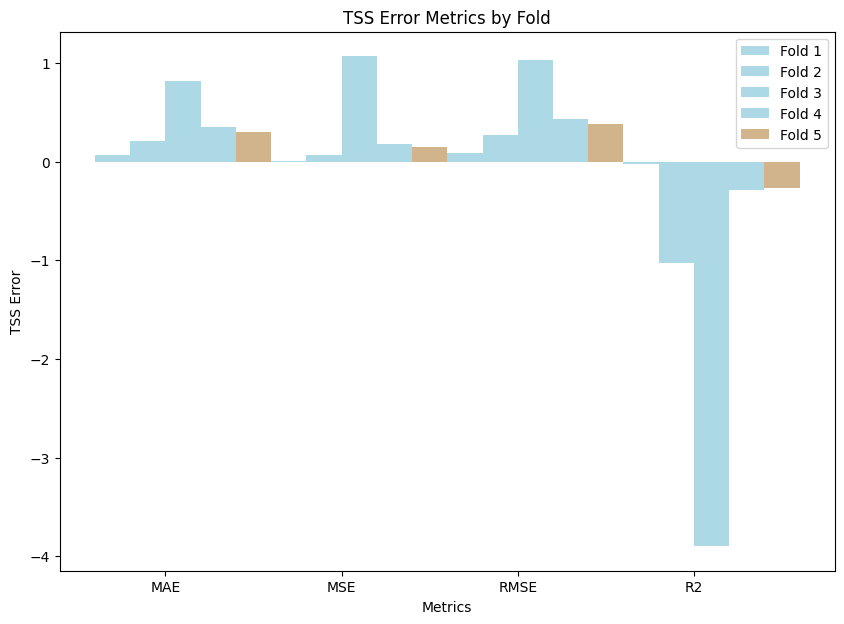

In [364]:
# Plot the time series cross validation vs baseline error metrics
num_folds = len(TSS_error_metrics_folds)
fold_lists = []

for i in range(num_folds):
    fold = [TSS_error_metrics_folds[j][i] for j in range(len(TSS_error_metrics_folds))]
    fold_lists.append(fold)

baseline_values = [mae_baseline, mse_baseline, rmse_baseline, r2_baseline]

labels = ['MAE', 'MSE', 'RMSE', 'R2']
bar_width = 0.2

fig, ax = plt.subplots(figsize=(10, 7))

# Create bars
for i, fold in enumerate(fold_lists):
    r = np.arange(len(fold)) + i * bar_width
    plt.bar(r, fold, width=bar_width, color='lightblue')

# Create baseline bars
r = [x + bar_width * num_folds for x in range(len(baseline_values))]
plt.bar(r, baseline_values, width=bar_width, label='Baseline (24h)', color='tan')

# Add xticks and labels
plt.title('Time Series Cross Validation vs Baseline')
plt.xticks([r + bar_width*1.5 for r in range(len(labels))], labels)
plt.xlabel('Metrics')
plt.ylabel('TSS Error')
plt.title('TSS Error Metrics by Fold')
plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
plt.show()

